In [1]:
import sys; print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend(['C:\\Users\\user\\PycharmProjects\\Open_Close_GNN'])

Python 3.11.2 (tags/v3.11.2:878ead1, Feb  7 2023, 16:38:35) [MSC v.1934 64 bit (AMD64)] on win32


In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from seaborn import heatmap
from sklearn.model_selection import GroupKFold
from torch.optim import lr_scheduler
from torch.utils.data import SubsetRandomSampler
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm

from model.dataset import OpenCloseDataset
from model.gnn_model import GCN, GATv2
from model.utils import device, eval_epoch, train, train_epoch, load_data_and_groups

import pickle

In [3]:
np.random.seed(42)

In [4]:
closed, opened, groups, labels = load_data_and_groups(
    pickle_path=r'C:\Users\user\YandexDisk\IHB\Projects\OpenCloseFMRI\data\FC_matrix\FC_IHB.pickle',
    filename='HCPex_aCompCor10_24P')

In [5]:
full_dataset = OpenCloseDataset(datafolder='../new_data/', 
                                open_file=opened, close_file=closed, 
                                reload=True, k_degree=40, threshold=None)

Processing...
Done!


In [6]:
gkf = GroupKFold()
for i, (train_index, val_test_index) in enumerate(gkf.split(labels, groups=groups)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}, groups={groups[train_index]}")
    print(f"  Test:  index={val_test_index}, group={groups[val_test_index]}")
    break

Fold 0:
  Train: index=[  0   1   2   4   5   6   7   9  10  11  12  14  15  16  17  18  20  21
  22  23  24  26  27  28  29  31  32  33  34  36  37  38  40  41  42  44
  45  46  47  49  50  51  52  54  55  56  57  59  60  61  62  63  65  66
  67  68  70  71  72  73  75  76  77  78  80  82  83  84  86  87  88  89
  91  92  93  94  96  97  98  99 100 102 103 104 105 106 108 109 110 111
 113 114 115 116 118 119 120 122 123 124 126 127 128 129 131 132 133 134
 136 137 138 139 141 142 143 144 145 147 148 149 150 152 153 154 155 157
 158 159 160 162], groups=[ 0  1  2  4  5  6  7  9 10 11 12 14 15 16 17 18 20 21 22 23 24 26 27 28
 29 31 32 33 34 36 37 38 40 41 42 44 45 46 47 49 50 51 52 54 55 56 57 59
 60 61 62 63 65 66 67 68 70 71 72 73 75 76 77 78 80  0  1  2  4  5  6  7
  9 10 11 12 14 15 16 17 18 20 21 22 23 24 26 27 28 29 31 32 33 34 36 37
 38 40 41 42 44 45 46 47 49 50 51 52 54 55 56 57 59 60 61 62 63 65 66 67
 68 70 71 72 73 75 76 77 78 80]
  Test:  index=[  3   8  13  19  25  30  35

In [7]:
train_loader = DataLoader(full_dataset, batch_size=32, shuffle=False, sampler=SubsetRandomSampler(train_index))
val_loader = DataLoader(full_dataset, batch_size=32, shuffle=False, sampler=SubsetRandomSampler(val_test_index))
#test_loader = DataLoader(full_dataset, batch_size=8, shuffle=False, sampler=SubsetRandomSampler(val_test_index[35:]))

## GCN

In [25]:
torch.cuda.empty_cache()

In [26]:
model = GCN(full_dataset.num_features, channels=[128, 32], dropout=0.7).to(device())
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()
epochs = 50
scheduler = lr_scheduler.StepLR(optimizer, step_size=epochs//5, gamma=0.1, last_epoch=-1, verbose=True)
sum(p.numel() for p in model.parameters())

Adjusting learning rate of group 0 to 1.0000e-03.


59106

In [27]:
history = train(model, epochs, train_loader, val_loader, loss, optimizer, 
                scheduler=scheduler, save_best=False, path_to_save='../weights/whatever.pt')

  0%|          | 0/50 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 001, Train Loss: 0.6612, Test Loss 0.6802, Train Acc: 0.5938, Test Acc: 0.5000
Test precision: 0.0000, Test recall: 0.0000, Test F1: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 002, Train Loss: 0.6609, Test Loss 0.6363, Train Acc: 0.7750, Test Acc: 0.7812
Test precision: 0.7632, Test recall: 0.8333, Test F1: 0.7941
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 003, Train Loss: 0.6567, Test Loss 0.6874, Train Acc: 0.7375, Test Acc: 0.5312
Test precision: 0.5250, Test recall: 0.8438, Test F1: 0.6389
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 004, Train Loss: 0.6363, Test Loss 0.6103, Train Acc: 0.6875, Test Acc: 0.8125
Test precision: 0.5000, Test recall: 0.1471, Test F1: 0.2273
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 005, Train Loss: 0.5945, Test Loss 0.6640, Train Acc: 0.7188, Test Acc: 0.5312
Test precision: 0.5000, Test recall: 0.0625, Test F1: 0.1111
Adjusting learn

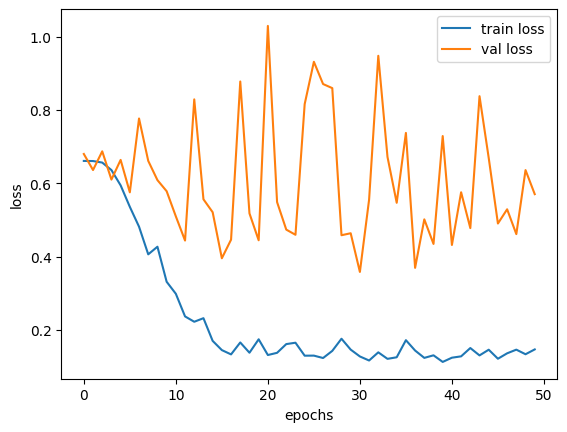

In [28]:
train_loss, val_loss, train_acc, test_acc = zip(*history)
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend();

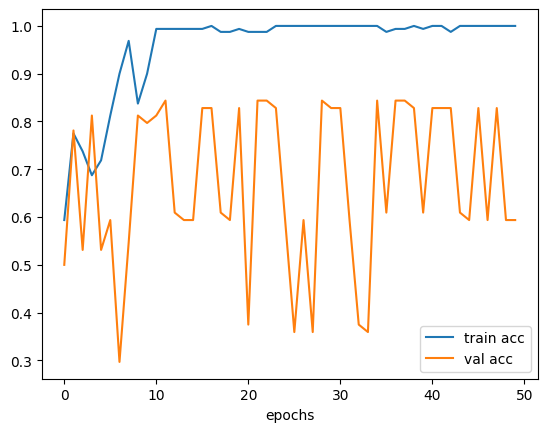

In [29]:
plt.plot(train_acc, label='train acc')
plt.plot(test_acc, label='val acc')
plt.xlabel('epochs')
plt.legend();

In [30]:
np.mean(test_acc)

0.6734375

In [67]:
model.load_state_dict(torch.load('../weights/gcn_128_32_05_acc_09.pt', map_location=device()))

<All keys matched successfully>

# Group kFold

In [31]:
# GCN
channels = [32, 8]
n_epochs = 30
lr = 0.001
skf = GroupKFold(n_splits=10)
eval_metrics = np.zeros((skf.n_splits, 4))
crossval_dataset = full_dataset #+ val_dataset

labels = [crossval_dataset[i].y for i in range(len(crossval_dataset))]


for n_fold, (train_idx, test_idx) in tqdm(enumerate(skf.split(labels, groups=groups))):
    torch.cuda.empty_cache()
    model = GCN(crossval_dataset.num_features, channels=channels, dropout=0.3).to(device())
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    scheduler = lr_scheduler.StepLR(optimizer, step_size=30//3, gamma=0.1, last_epoch=-1, verbose=False)

    train_loader_ = DataLoader(crossval_dataset[list(train_idx)], batch_size=16, shuffle=True)
    test_loader_ = DataLoader(crossval_dataset[list(test_idx)], batch_size=16, shuffle=True)
    min_v_loss = np.inf
    print(n_fold)
    pr, rc, acc = [], [], []
    for epoch in range(n_epochs):
        train_epoch(train_loader_, model, criterion, optimizer)
        train_loss, train_acc, _, _, train_f1 = eval_epoch(train_loader_, model, criterion)
        val_loss, test_acc, _, _, test_f1 = eval_epoch(test_loader_, model, criterion)
        scheduler.step()
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss {val_loss:.4f},',
              f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Test F1: {test_f1:.4f}')

        pr.append(test_f1)
        acc.append(test_acc)
        if min_v_loss > val_loss:
            min_v_loss = val_loss
            best_test_acc = test_acc

    eval_metrics[n_fold, 0] = best_test_acc
    eval_metrics[n_fold, 1] = np.mean(acc)
    eval_metrics[n_fold, 2] = np.std(acc)
    eval_metrics[n_fold, 3] = np.mean(pr)

0it [00:00, ?it/s]

0
Epoch: 000, Train Loss: 0.6850, Test Loss 0.7466, Train Acc: 0.5000, Test Acc: 0.2812, Test F1: 0.0000
Epoch: 001, Train Loss: 0.6614, Test Loss 0.7099, Train Acc: 0.6687, Test Acc: 0.2812, Test F1: 0.3158
Epoch: 002, Train Loss: 0.6333, Test Loss 0.6917, Train Acc: 0.7375, Test Acc: 0.5000, Test F1: 0.6111
Epoch: 003, Train Loss: 0.5727, Test Loss 0.5551, Train Acc: 0.7937, Test Acc: 0.7188, Test F1: 0.7353
Epoch: 004, Train Loss: 0.5011, Test Loss 0.5718, Train Acc: 0.8313, Test Acc: 0.7500, Test F1: 0.7143
Epoch: 005, Train Loss: 0.4677, Test Loss 0.6407, Train Acc: 0.8813, Test Acc: 0.8125, Test F1: 0.8125
Epoch: 006, Train Loss: 0.4084, Test Loss 0.5131, Train Acc: 0.8938, Test Acc: 0.8438, Test F1: 0.8529
Epoch: 007, Train Loss: 0.3906, Test Loss 0.7010, Train Acc: 0.8625, Test Acc: 0.5625, Test F1: 0.3636
Epoch: 008, Train Loss: 0.3516, Test Loss 0.6464, Train Acc: 0.8875, Test Acc: 0.6250, Test F1: 0.4000
Epoch: 009, Train Loss: 0.2913, Test Loss 0.5383, Train Acc: 0.9625, Te

In [32]:
print(np.mean(eval_metrics[:, 0])) # 0.7614)
print(np.std(eval_metrics[:, 0]))
print(np.mean(eval_metrics[:, 3]))


0.765625
0.08529590039972614
0.6974999129772186


In [83]:
np.mean(eval_metrics[:, 2])

0.07113302685320377

In [85]:
np.mean(eval_metrics[:, 1])

0.6536309540271759

# Graph density

In [ ]:
from torch_geometric.nn import knn_graph

tg = knn_graph(torch.tensor(close_file1[5]).cuda(), 10, cosine=True)

In [ ]:
mattg = to_dense_adj(tg)

<Axes: >

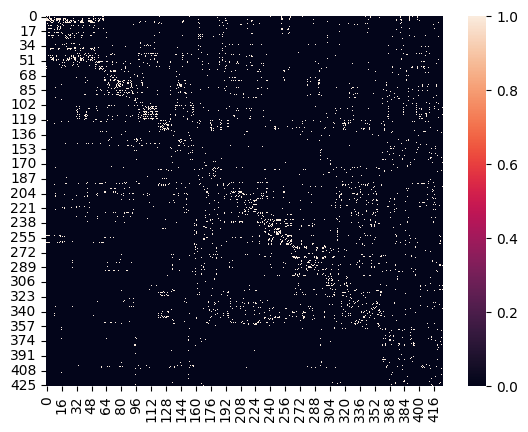

In [ ]:
heatmap(mattg.squeeze().cpu())

In [ ]:
mat10 = full_dataset.compute_KNN_graph(close_file1[5], 10)

<Axes: >

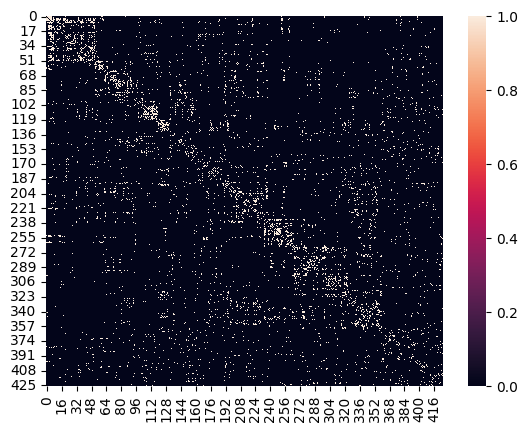

In [ ]:
heatmap(mat10>0)

In [ ]:
# hcp k = 50
np.sum(mat10 > 0) / (mat10.shape[1] * mat10.shape[0])

0.16171835394211906

In [ ]:
# hcp k = 10
np.sum(mat10 > 0) / (mat10.shape[1] * mat10.shape[0])

0.036203134298750245

In [ ]:
# aal k = 10 
np.sum(mat10 > 0) / (mat10.shape[1] * mat10.shape[0])

0.12425683709869204

In [ ]:
# aal k = 5 
np.sum(mat10 > 0) / (mat10.shape[1] * mat10.shape[0])

0.06450653983353151